Mounted at /content/drive
Creating data generators...
Found 3216 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4951 - loss: 0.7186 - precision: 0.4951 - recall: 0.4951
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to nutrition_model-001-0.5000.keras
402/402 ━━━━━━━━━━━━━━━━━━━━ 2122s 5s/step - accuracy: 0.4951 - loss: 0.7186 - precision: 0.4951 - recall: 0.4951 - val_accuracy: 0.5000 - val_loss: 0.7038 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4817 - loss: 0.7028 - precision: 0.4817 - recall: 0.4817
Epoch 2: val_accuracy improved from 0.50000 to 0.53741, saving model to nutrition_model-002-0.5374.keras
402/402 ━━━━━━━━━━━━━━━━━━━━ 1577s 4s/step - accuracy: 0.4818 - loss: 0.7028 - precision: 0.4818 - recall: 0.4818 - val_accuracy: 0.5374 - val_loss: 0.7001 - val_precision: 0.5374 - val_recall: 0.5374 - learning_rate: 0.0010
Epoch 3/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5463 - loss: 0.6944 - precision: 0.5463 - rec

Model saved as 'final_nutrition_model.h5'.


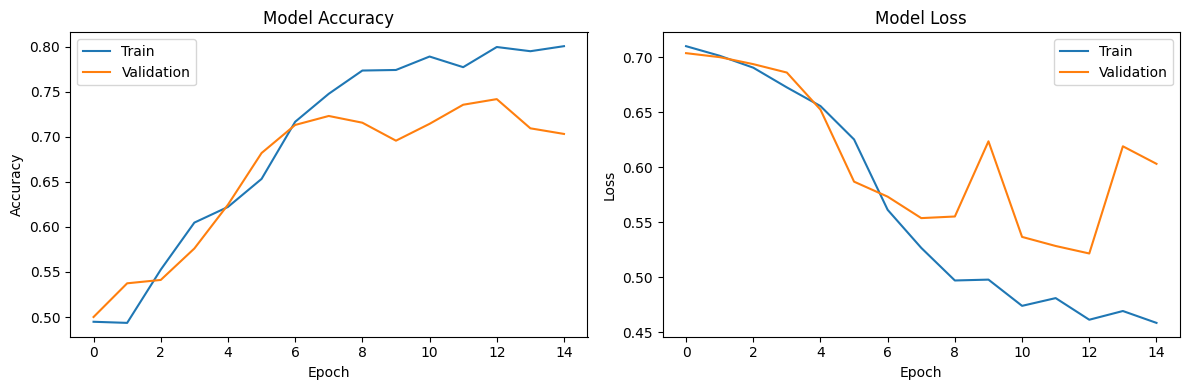

101/101 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7051 - loss: 0.5662 - precision: 0.7051 - recall: 0.7051
Validation Loss: 0.5405
Validation Accuracy: 0.7145
Validation Precision: 0.7145
Validation Recall: 0.7145
101/101 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step
Validation F1-Score: 0.7293

Classification Report:
                     precision    recall  f1-score   support

Non Nutrition Facts       0.74      0.71      0.72       401
    Nutrition Facts       0.72      0.75      0.74       401

           accuracy                           0.73       802
          macro avg       0.73      0.73      0.73       802
       weighted avg       0.73      0.73      0.73       802



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    GlobalAveragePooling2D, Input, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.regularizers import l2

# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 8  # Smaller batch size to improve gradient updates
NUM_CLASSES = 2
TRAIN_PATH = '/content/drive/MyDrive/DATASET TRAIN'

# Mount Google Drive
drive.mount('/content/drive')

def create_data_generators():
    """
    Creates training and validation data generators with enhanced augmentation.
    """
    print("Creating data generators...")
    if not os.path.exists(TRAIN_PATH):
        raise ValueError(f"Training path not found: {TRAIN_PATH}")

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=[0.8, 1.5],
        brightness_range=[0.6, 1.4],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        classes=['Non Nutrition Facts', 'Nutrition Facts'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        classes=['Non Nutrition Facts', 'Nutrition Facts'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator

def create_simple_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    """
    Creates a simplified CNN model with dropout and L2 regularization.
    """
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)

    # Fully connected layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    train_generator, validation_generator = create_data_generators()

    if train_generator and validation_generator:
        model = create_simple_cnn()

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        checkpoint = ModelCheckpoint('nutrition_model-{epoch:03d}-{val_accuracy:.4f}.keras',
                                      monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

        # Training
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=15,
            callbacks=[checkpoint, early_stopping, reduce_lr]
        )

        # Save the final model
        model.save('final_nutrition_model.h5')
        print("Model saved as 'final_nutrition_model.h5'.")

        # Plot training history
        plot_training_history(history)

        # Evaluate model on validation set
        val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Precision: {val_precision:.4f}")
        print(f"Validation Recall: {val_recall:.4f}")

        # Calculate F1-Score and classification report
        val_preds = model.predict(validation_generator)
        val_y_true = validation_generator.classes
        val_y_pred = np.argmax(val_preds, axis=-1)

        f1 = f1_score(val_y_true, val_y_pred, average='weighted')
        print(f"Validation F1-Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(val_y_true, val_y_pred, target_names=['Non Nutrition Facts', 'Nutrition Facts']))

    else:
        print("Failed to create data generators.")


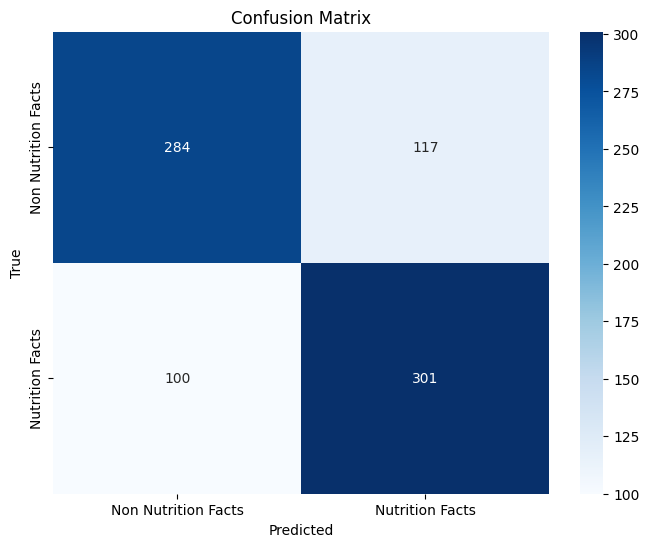

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(val_y_true, val_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Nutrition Facts', 'Nutrition Facts'], yticklabels=['Non Nutrition Facts', 'Nutrition Facts'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


101/101 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step


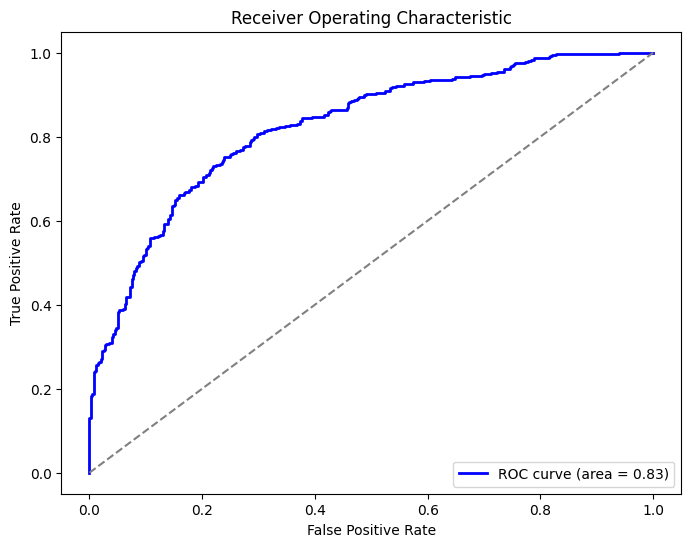

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_true, y_pred_prob, class_labels):
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=[0, 1])

    # Compute ROC curve and AUC for each class
    fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Predict probabilities for ROC
val_preds_prob = model.predict(validation_generator)

plot_roc_curve(val_y_true, val_preds_prob[:, 1], ['Non Nutrition Facts', 'Nutrition Facts'])


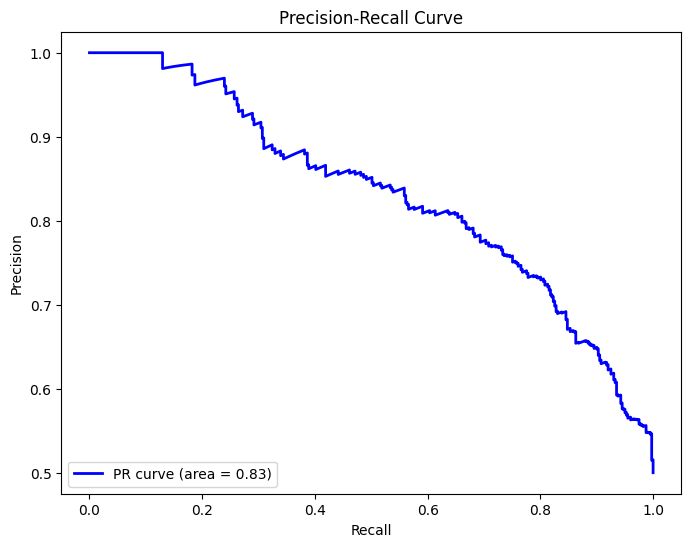

In [12]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_true, y_pred_prob, class_labels):
    # Compute Precision-Recall curve and AUC
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Predict probabilities for Precision-Recall
plot_precision_recall_curve(val_y_true, val_preds_prob[:, 1], ['Non Nutrition Facts', 'Nutrition Facts'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Class: Nutrition Facts
Confidence: 69.96%


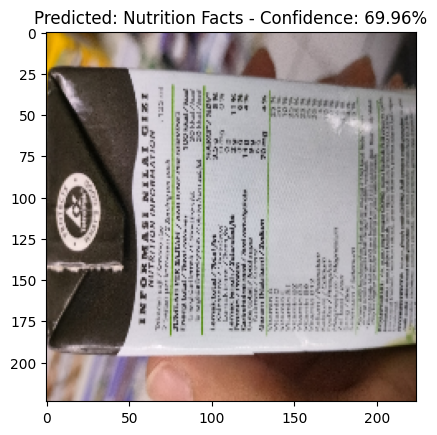

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted Class: Nutrition Facts
Confidence: 86.51%


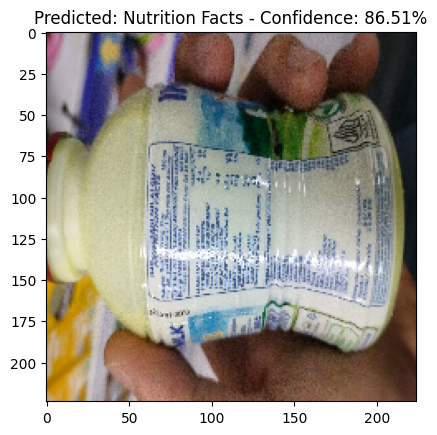

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Class: Nutrition Facts
Confidence: 57.62%


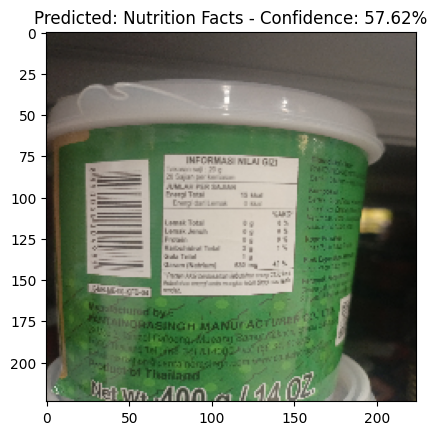

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted Class: Non Nutrition Facts
Confidence: 84.56%


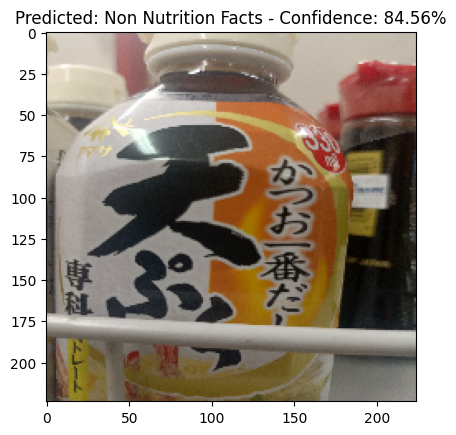

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted Class: Non Nutrition Facts
Confidence: 64.05%


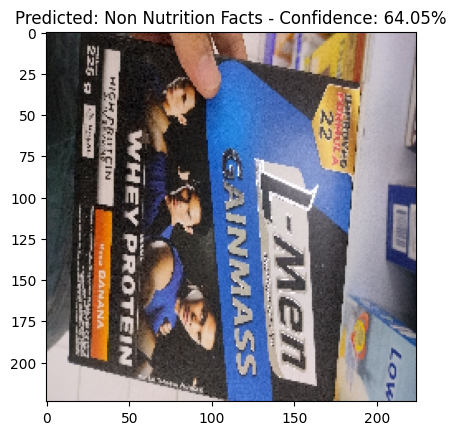

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Class: Non Nutrition Facts
Confidence: 88.38%


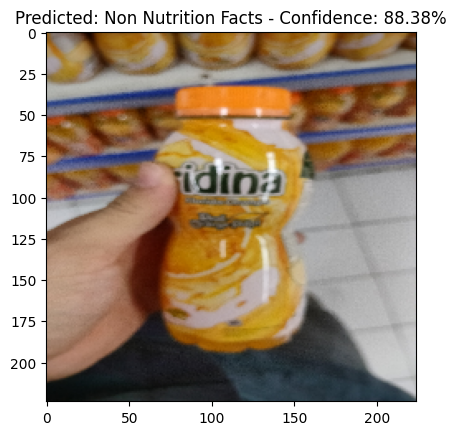

In [20]:
def predict_on_new_images(model, image_paths, img_height=224, img_width=224):
    for img_path in image_paths:
        load_and_predict_image(img_path, model, img_height, img_width)

# Example usage:
new_image_paths = [
    '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG20241113171035.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG20241113171228.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_150023_648.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Non Nutrition Facts/IMG_20241126_165402_305.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Non Nutrition Facts/IMG20241113170652.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Non Nutrition Facts/IMG20241113174057.jpg'


]
predict_on_new_images(model, new_image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted Class: Nutrition Facts
Confidence: 86.02%


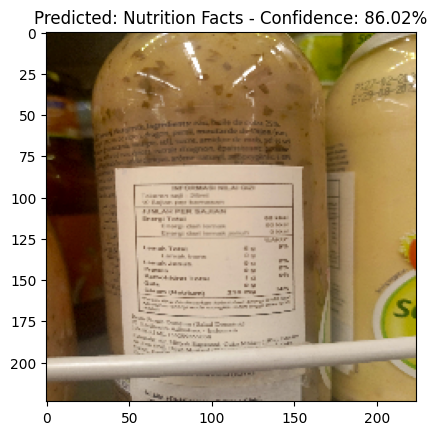

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_predict_image(image_path, model, img_height=224, img_width=224):
    """
    Loads an image, preprocesses it, and makes a prediction using the trained model.
    """
    # Load the image file, resizing it to match model's expected sizing
    img = image.load_img(image_path, target_size=(img_height, img_width))

    # Convert the image to a numpy array and scale pixel values to [0, 1]
    img_array = image.img_to_array(img) / 255.0

    # Add an extra dimension to the image array (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    predictions = model.predict(img_array)

    # Get the predicted class and the corresponding confidence
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions) * 100  # Max probability in percentage
    class_labels = ['Non Nutrition Facts', 'Nutrition Facts']

    print(f"Predicted Class: {class_labels[predicted_class[0]]}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class[0]]} - Confidence: {confidence:.2f}%")
    plt.show()

# Example usage:
image_path = '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_145735_539.jpg'  # Replace with your image file path
load_and_predict_image(image_path, model)


In [38]:
loaded_model = tf.keras.models.load_model('/content/final_nutrition_model.h5')

In [40]:
def detect_nutrition_facts(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be loaded.")
        return None, 0.0, None

    img_orig = img.copy()
    img_height, img_width = img.shape[:2]

    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    nutrition_box = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.4 <= aspect_ratio <= 3.0 and w * h > (img_height * img_width * 0.02):
                nutrition_box = approx
                break

    if nutrition_box is not None:
        cv2.drawContours(img_orig, [nutrition_box], -1, (0, 255, 0), 2)

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [nutrition_box], -1, (255), -1)
        result = cv2.bitwise_and(img_orig, img_orig, mask=mask)

        result = cv2.resize(result, (IMG_WIDTH, IMG_HEIGHT))
        result = result / 255.0
        result = np.expand_dims(result, axis=0)

        prediction = model.predict(result)
        class_index = np.argmax(prediction, axis=1)[0]
        confidence = prediction[0][class_index]

        predicted_class = 'Nutrition Fact' if class_index == 1 else 'Non Nutrition Fact'
        print(f"Detected {predicted_class} with confidence: {confidence:.2f}")
        return img_orig, confidence, predicted_class, nutrition_box
    else:
        return img_orig, 0.0, None, None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted Class: Nutrition Facts
Confidence: 73.19%


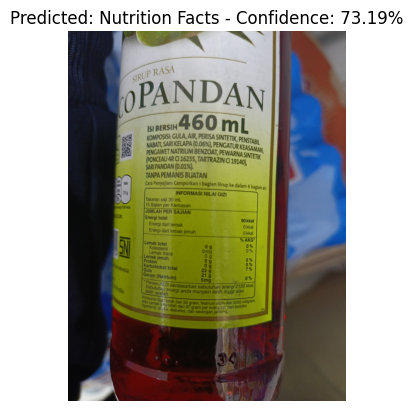

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Detected Nutrition Fact with confidence: 0.85


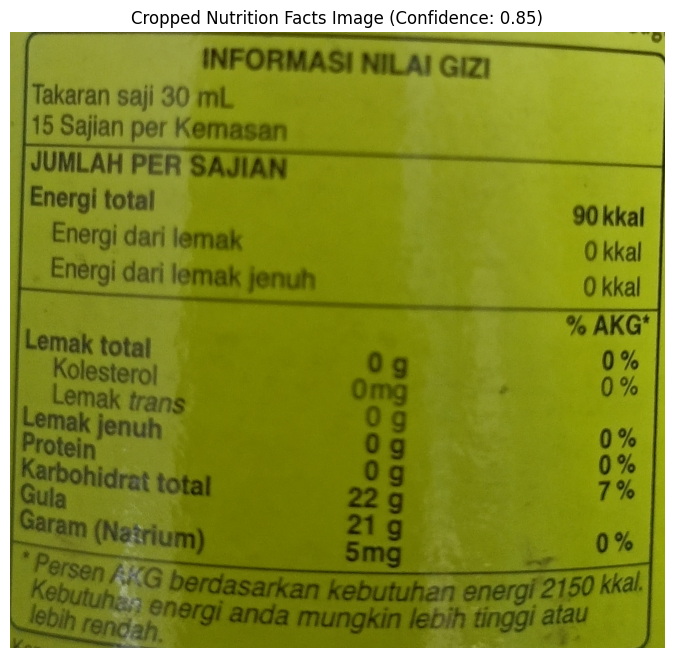

In [45]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_predict_image(image_path, model, img_height=224, img_width=224):
    """
    Loads an image, preprocesses it, and makes a prediction using the trained model.
    """
    # Load the image for prediction
    img_for_pred = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img_for_pred) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Load the image for display (original size)
    img_for_display = image.load_img(image_path)

    # Make the prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions) * 100  # Max probability in percentage
    class_labels = ['Non Nutrition Facts', 'Nutrition Facts']

    print(f"Predicted Class: {class_labels[predicted_class[0]]}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image in its original size
    plt.imshow(img_for_display)
    plt.title(f"Predicted: {class_labels[predicted_class[0]]} - Confidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return class_labels[predicted_class[0]], confidence

def crop_nutrition_facts(image_path, contour):
    """
    Crops an image based on the bounding rectangle of a given contour.
    """
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be loaded.")
        return None

    # Crop based on the bounding box
    x, y, w, h = cv2.boundingRect(contour)
    cropped_image = img[y:y+h, x:x+w]

    return cropped_image

def detect_and_crop(image_path, model, detect_func, img_height=224, img_width=224):
    """
    Detects nutrition facts in an image, predicts its presence, and crops the relevant region.
    """
    if not os.path.exists(image_path):
        print(f"Error: The image file does not exist at the specified path: {image_path}")
        return

    # Prediction and detection
    predicted_class, confidence = load_and_predict_image(image_path, model, img_height, img_width)
    if predicted_class == "Nutrition Facts":
        result_image, confidence, predicted_class, contour = detect_func(image_path, model)
        if contour is not None:
            cropped_image = crop_nutrition_facts(image_path, contour)

            # Display the cropped image
            if cropped_image is not None:
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                plt.title(f'Cropped Nutrition Facts Image (Confidence: {confidence:.2f})')
                plt.axis('off')
                plt.show()
        else:
            print("No nutrition facts detected in the image.")
    else:
        print("Prediction indicates the image does not contain Nutrition Facts.")

# Example usage:
test_image_path = "/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241121_114305_694.jpg"  # Replace with your test image path
detect_and_crop(test_image_path, loaded_model, detect_nutrition_facts)
